In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from catboost import  CatBoostClassifier
from sklearn.metrics import roc_auc_score
import json
import random
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_trx = pd.read_csv('blockchain_data.csv', header=None)
df_trx.rename(columns={0: "dt", 1: "wallet", 2: "tran_codes", 3: "amount", 4: "abuser"}, inplace=True)

In [3]:
df_trx = df_trx.fillna('0x00000000009a41862f3b2b0c688b7c0d19405144')

In [4]:
df_trx["amount"] = df_trx["amount"].apply(lambda x: (int(x)/10000000000000000)).astype('float')

In [5]:
df_trx.tran_codes = df_trx.tran_codes.astype('category')
df_trx.tran_codes = df_trx.tran_codes.cat.codes
df_trx.tran_codes = df_trx.tran_codes.astype('int')
df_trx.head()

,dt,wallet,tran_codes,amount,abuser
0,1512557355,0xbf87b66d590cd9e39ebfe6895ae4cc7aa50f249f,99,5.000000,0
1,1513335342,0xbf87b66d590cd9e39ebfe6895ae4cc7aa50f249f,99,52.429375,0
2,1514567762,0x004537fcd9095489ebe38180a382341b962b501d,17350,0.000000,0
3,1514570003,0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,99,89.362936,0
4,1514570293,0x004537fcd9095489ebe38180a382341b962b501d,15752,141.800000,0


In [7]:
act_vc = df_trx.tran_codes.value_counts()
selected_activities_codes = act_vc[act_vc > 20].keys().tolist()
len(selected_activities_codes)

198

In [8]:
def feature_generation(df_count,selected_activities_codes):
   
    train_feature=[]
    wallets = df_count['wallet'].unique().tolist()
   
    for wallet in tqdm(np.array(wallets)):
        
        wallet_history=df_count[df_count['wallet']==wallet]
        wallet_user = (wallet_history['wallet'].unique().tolist())
        targets = wallet_history['abuser'].unique().tolist()
        if 1 in targets:
            target = 1
        else:
            target = 0
      
        codes_trans=[]
        codes_features=[]
        
        for code in selected_activities_codes:
                code_df = wallet_history[wallet_history['tran_codes']==code]
                codes_features.append(str(code)+'_mean')
                codes_features.append(str(code)+'_median')
                codes_features.append(str(code)+'_max')
                codes_features.append(str(code)+'_min')
                codes_features.append(str(code)+'_count')
                codes_features.append(str(code)+'_std')
                codes_features.append(str(code)+'_sum')
               
                codes_trans.append(code_df.amount.mean())
                codes_trans.append(code_df.amount.median())
                codes_trans.append(code_df.amount.max())
                codes_trans.append(code_df.amount.min())
                codes_trans.append(len(code_df))
                codes_trans.append(code_df.amount.std())
                codes_trans.append(code_df.amount.sum())
                
                
        trans=[]
        features=[]       
        features.append(str('wallet_history')+'_mean')
        features.append(str('wallet_history')+'_median')
        features.append(str('wallet_history')+'_max')
        features.append(str('wallet_history')+'_min')
        features.append(str('wallet_history')+'_count')
        features.append(str('wallet_history')+'_std')
        features.append(str('wallet_history')+'_sum')
               
        trans.append(wallet_history.amount.mean())
        trans.append(wallet_history.amount.median())
        trans.append(wallet_history.amount.max())
        trans.append(wallet_history.amount.min())
        trans.append(len(wallet_history))
        trans.append(wallet_history.amount.std())
        trans.append(wallet_history.amount.sum())
               
        feature=[*wallet_user,target]+ trans + codes_trans 
 
        train_feature.append(feature)
               
    return pd.DataFrame(train_feature, columns = ['wallet','target']+features+codes_features)

In [9]:
train_data = feature_generation(df_trx,selected_activities_codes)

100%|████████████████████████████████████████████████████████████████████████████| 15809/15809 [43:27<00:00,  6.06it/s]


In [10]:
train_data.head()

,wallet,target,wallet_history_mean,wallet_history_median,wallet_history_max,wallet_history_min,wallet_history_count,wallet_history_std,wallet_history_sum,12724_mean,...,7193_count,7193_std,7193_sum,13270_mean,13270_median,13270_max,13270_min,13270_count,13270_std,13270_sum
0,0xbf87b66d590cd9e39ebfe6895ae4cc7aa50f249f,0,76.914798,31.214688,336.630040,5.000000,6,129.206923,461.488790,NaN,...,0,NaN,0.0,NaN,NaN,NaN,NaN,0,NaN,0.0
1,0x004537fcd9095489ebe38180a382341b962b501d,0,28.360000,0.000000,141.800000,0.000000,10,59.788130,283.600000,NaN,...,0,NaN,0.0,NaN,NaN,NaN,NaN,0,NaN,0.0
2,0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,1,515.908427,52.617821,19664.578983,0.400000,255,1859.758995,131556.648822,NaN,...,0,NaN,0.0,NaN,NaN,NaN,NaN,0,NaN,0.0
3,0x564286362092d8e7936f0549571a803b203aaced,1,395.117295,50.694029,6500.000000,0.500000,246,1107.141099,97198.854585,NaN,...,0,NaN,0.0,NaN,NaN,NaN,NaN,0,NaN,0.0
4,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,1,469.135883,69.435193,17854.978615,1.464533,124,1796.013464,58172.849509,NaN,...,0,NaN,0.0,NaN,NaN,NaN,NaN,0,NaN,0.0


In [12]:
train_data.to_csv('train_data.csv', index=False)

In [13]:
train_data['target'].value_counts()

target
0    10030
1     5779
Name: count, dtype: int64

In [14]:
train_data = train_data.fillna(0)# отсутствующие признаки по юзеру заполним нулями

In [15]:
X_train=train_data.drop(['wallet','target'],axis=1)
target=train_data.target

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

model = CatBoostClassifier()

skfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
oof = np.zeros(len(train_data))
predictions = []
models=[]
for fold, (trn_idx, val_idx) in enumerate(skfold.split(X_train, target)):
    print(f'Fold {fold + 1}')
    X_tr, y_tr = X_train.iloc[trn_idx], target.iloc[trn_idx]
    X_valid, y_valid = X_train.iloc[val_idx], target.iloc[val_idx]
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_valid, y_valid)],
        verbose=50,
        early_stopping_rounds=50,
    )

        
    oof[val_idx] = model.predict_proba(X_valid)[:, 1]
    print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))
    print(f'Результат Accuracy на fold {fold + 1} {(accuracy_score(y_valid, model.predict(X_valid)))}')
    print(f'Результат F1 на fold {fold + 1} {f1_score(y_valid, model.predict(X_valid), average="macro")}')
print(f'Результат Roc_auc {roc_auc_score(target, oof)}')

Fold 1
Learning rate set to 0.060325
0:	learn: 0.6803473	test: 0.6812161	best: 0.6812161 (0)	total: 182ms	remaining: 3m 2s
50:	learn: 0.5460477	test: 0.5511646	best: 0.5511646 (50)	total: 1.38s	remaining: 25.7s
100:	learn: 0.5234051	test: 0.5302911	best: 0.5302911 (100)	total: 2.57s	remaining: 22.9s
150:	learn: 0.5087434	test: 0.5182605	best: 0.5182605 (150)	total: 3.73s	remaining: 21s
200:	learn: 0.4932015	test: 0.5055962	best: 0.5055962 (200)	total: 4.88s	remaining: 19.4s
250:	learn: 0.4808976	test: 0.4974871	best: 0.4974871 (250)	total: 6.04s	remaining: 18s
300:	learn: 0.4711481	test: 0.4923376	best: 0.4922798 (298)	total: 7.2s	remaining: 16.7s
350:	learn: 0.4621490	test: 0.4873754	best: 0.4873503 (348)	total: 8.38s	remaining: 15.5s
400:	learn: 0.4545916	test: 0.4835877	best: 0.4835877 (400)	total: 9.56s	remaining: 14.3s
450:	learn: 0.4486170	test: 0.4818222	best: 0.4817692 (447)	total: 10.8s	remaining: 13.1s
500:	learn: 0.4439459	test: 0.4803967	best: 0.4803967 (500)	total: 11.9s	r

<Axes: ylabel='feature_names'>

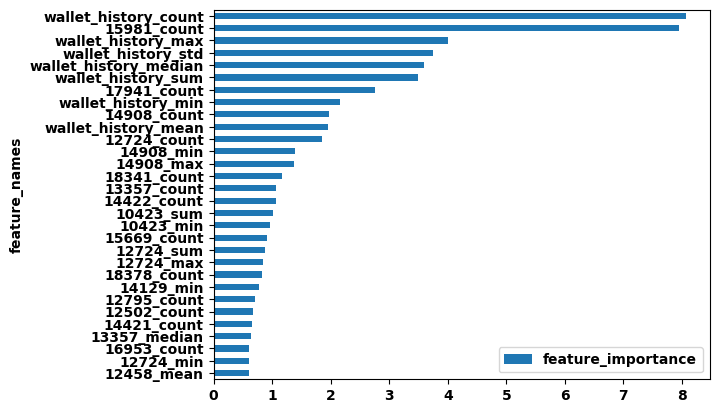

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.DataFrame({'feature_importance': model.feature_importances_, 
                    'feature_names': X_valid.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
data[:30].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

In [17]:
import pandas as pd
import numpy as np
from sklearn. model_selection import train_test_split
from sklearn. linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

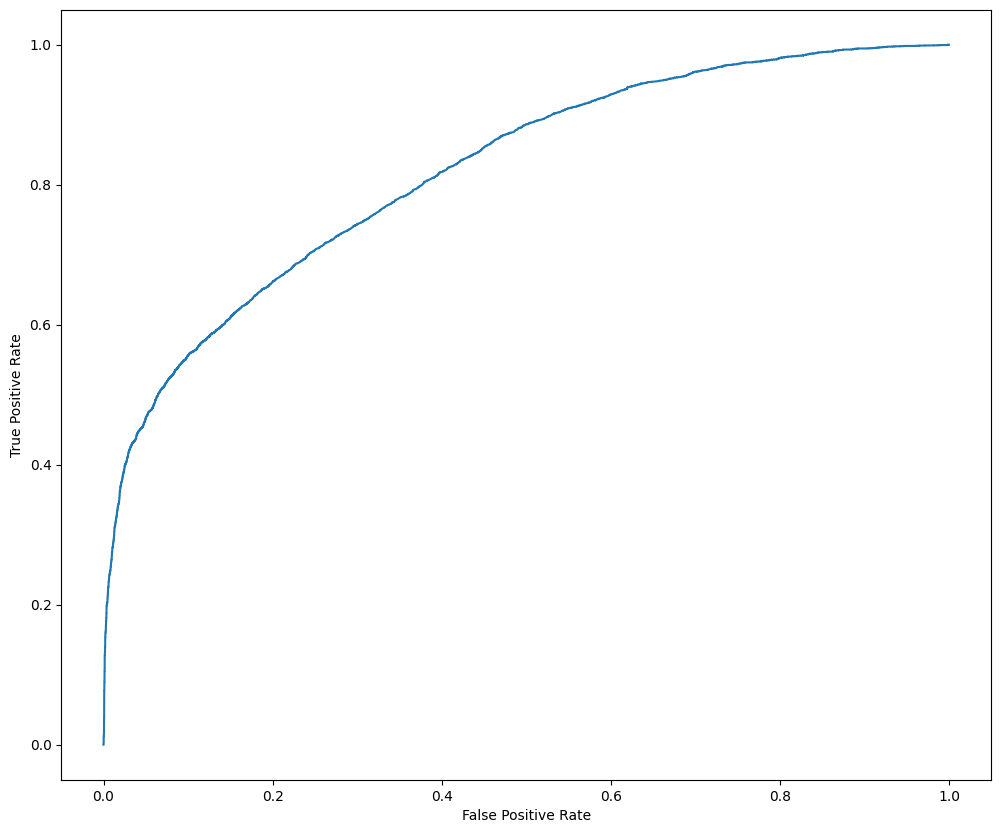

In [20]:
#define metrics
#y_pred_proba = log_regression. predict_proba (X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(target, oof)

#create ROC curve
fig, ax = plt.subplots(figsize=(12,10))
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

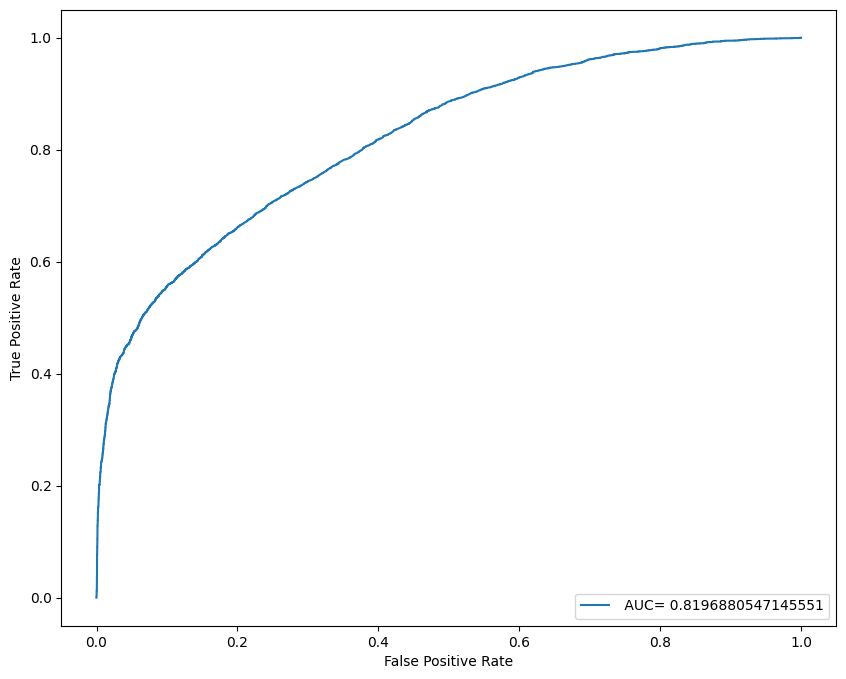

In [23]:
auc = roc_auc_score(target, oof)

fig, ax = plt.subplots(figsize=(10,8))
#create ROC curve
plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 